In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm

In [2]:
REBUILD_DATA = False
IMG_SIZE = 150
class Lego_Phases():
    PHASE_1 = "E:/Egyetem/5_felev/Temalab/lego_errors/phase_1"
    PHASE_2 = "E:/Egyetem/5_felev/Temalab/lego_errors/phase_2"
    PHASE_3 = "E:/Egyetem/5_felev/Temalab/lego_errors/phase_3"

    #TESTING ? 
    LABELS = {PHASE_1: 0, PHASE_2: 1, PHASE_3: 2}
    
    training_data= []
    
    
    def make_training_data(self):
        for label in self.LABELS:
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(3)[self.LABELS[label]]]) #set num of classes

                                
                    except Exception as e:
                        pass
        
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        
if REBUILD_DATA:
    legophases = Lego_Phases()
    legophases.make_training_data()


In [3]:
training_data = np.load("training_data.npy", allow_pickle=True)
print(len(training_data))

1408


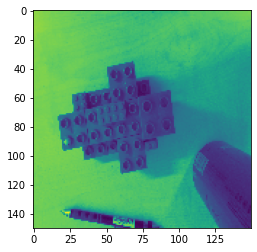

In [4]:
import matplotlib.pyplot as plt

plt.imshow(training_data[10][0])
plt.show()

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 conv
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        #random adat
        x = torch.randn(IMG_SIZE,IMG_SIZE).view(-1,1,IMG_SIZE,IMG_SIZE)
        self._to_linear = None
        self.convs(x) #átküldjük
        
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 3)  #set num of classes
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=28800, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
)


In [7]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
#optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=0.1)
loss_function = nn.MSELoss()

In [8]:
X = torch.Tensor([i[0] for i in training_data]).view(-1,IMG_SIZE,IMG_SIZE)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

In [9]:
VAL_PCT = 0.2
val_size = int(len(X)*VAL_PCT)
print(val_size)

281


In [10]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X), len(test_X))

1127 281


In [11]:
BATCH_SIZE = 50
EPOCHS = 70

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): #
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, IMG_SIZE, IMG_SIZE)
        batch_y = train_y[i:i+BATCH_SIZE]

        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    

    print(f"Epoch: {epoch}. Loss: {loss}")

  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 0. Loss: 0.221854567527771


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 1. Loss: 0.22001875936985016


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 2. Loss: 0.21081483364105225


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 3. Loss: 0.20204921066761017


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 4. Loss: 0.1581813246011734


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 5. Loss: 0.15697060525417328


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 6. Loss: 0.12564396858215332


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 7. Loss: 0.12021859735250473


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 8. Loss: 0.13391977548599243


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 9. Loss: 0.11044009029865265


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 10. Loss: 0.08583194017410278


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 11. Loss: 0.0978315994143486


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 12. Loss: 0.06735725700855255


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 13. Loss: 0.04816078394651413


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 14. Loss: 0.03543864190578461


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 15. Loss: 0.03176960349082947


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 16. Loss: 0.021100560203194618


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 17. Loss: 0.02077290043234825


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 18. Loss: 0.04337859898805618


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 19. Loss: 0.01510294433683157


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 20. Loss: 0.02972896583378315


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 21. Loss: 0.03328213840723038


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 22. Loss: 0.017711851745843887


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 23. Loss: 0.0066342782229185104


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 24. Loss: 0.014668087475001812


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 25. Loss: 0.005497338250279427


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 26. Loss: 0.006182389333844185


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 27. Loss: 0.015757838264107704


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 28. Loss: 0.0025554816238582134


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 29. Loss: 0.0014944939175620675


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 30. Loss: 0.006363857537508011


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 31. Loss: 0.016157638281583786


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 32. Loss: 0.003884720616042614


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 33. Loss: 0.01695461943745613


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 34. Loss: 0.0004341232415754348


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 35. Loss: 0.014384138397872448


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 36. Loss: 7.59430113248527e-05


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 37. Loss: 2.0707075236714445e-05


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 38. Loss: 1.856653943832498e-05


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 39. Loss: 6.649892020504922e-05


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 40. Loss: 6.636074976995587e-05


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 41. Loss: 0.0002433586778352037


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 42. Loss: 7.57869565859437e-05


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 43. Loss: 0.00014265807112678885


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 44. Loss: 5.131461512064561e-05


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 45. Loss: 8.769919077167287e-06


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 46. Loss: 4.113530394533882e-06


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 47. Loss: 2.074688018183224e-05


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 48. Loss: 1.7460290109738708e-05


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 49. Loss: 5.0016756176773924e-06


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 50. Loss: 1.9248116586823016e-05


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 51. Loss: 2.0176346879452467e-05


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 52. Loss: 1.8091088804794708e-06


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 53. Loss: 3.3545904443599284e-05


 48%|███████████████████████████████████████▏                                          | 11/23 [00:40<00:44,  3.72s/it]


KeyboardInterrupt: 

In [12]:
y_pred = []
y_test = []

bad_dec = []
real = []
bad_num = 0
bad_pics = []

correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, IMG_SIZE, IMG_SIZE))[0]  # returns a list, 
        predicted_class = torch.argmax(net_out)
        y_pred.append(predicted_class)
        y_test.append(real_class)
        if predicted_class == real_class:
            correct += 1
        else:
            bad_num += 1
            bad_dec.append(predicted_class)
            real.append(real_class)
            bad_pics.append(test_X[i])
            
        total += 1
print("Accuracy: ", round(correct/total, 3))

100%|████████████████████████████████████████████████████████████████████████████████| 281/281 [00:09<00:00, 29.78it/s]

Accuracy:  0.904


In [13]:
print(len(y_test))
#print(y_test)

print(len(y_pred))
#print(y_pred)

281
281


In [14]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
cm

array([[83,  1,  4],
       [ 6, 82,  8],
       [ 5,  3, 89]], dtype=int64)

Text(69.0, 0.5, 'Truth')

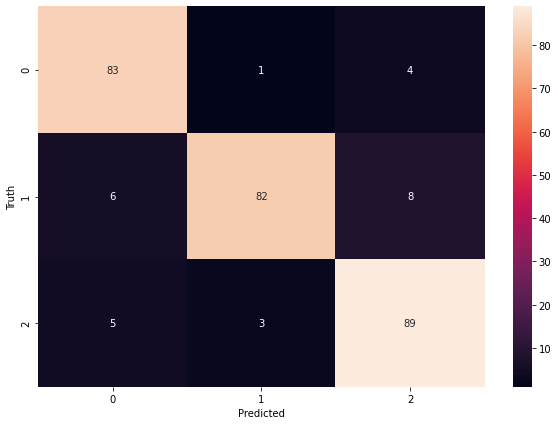

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

Valos:  1 , tippelt:  2


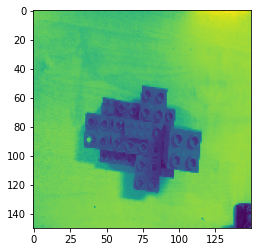

Valos:  1 , tippelt:  0


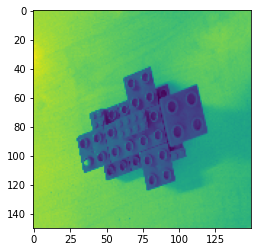

Valos:  1 , tippelt:  2


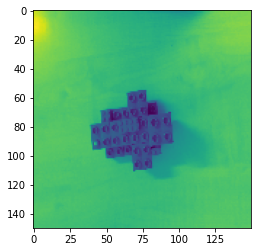

Valos:  0 , tippelt:  2


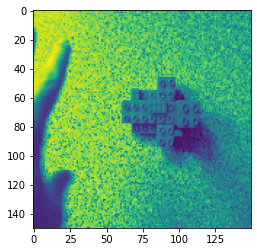

Valos:  2 , tippelt:  0


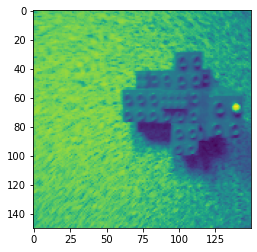

Valos:  2 , tippelt:  1


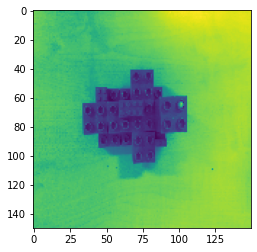

Valos:  1 , tippelt:  2


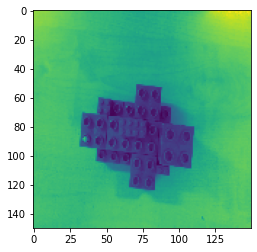

Valos:  0 , tippelt:  2


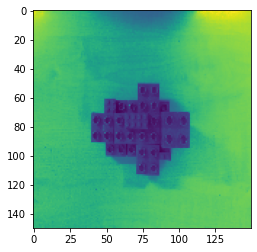

Valos:  2 , tippelt:  1


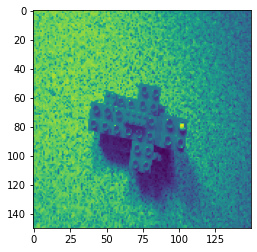

Valos:  2 , tippelt:  0


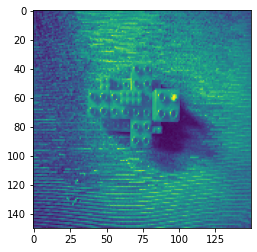

Valos:  2 , tippelt:  0


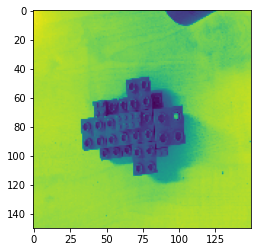

Valos:  0 , tippelt:  1


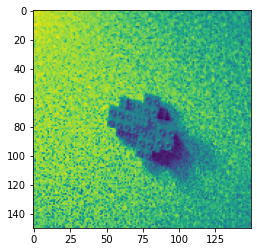

Valos:  1 , tippelt:  2


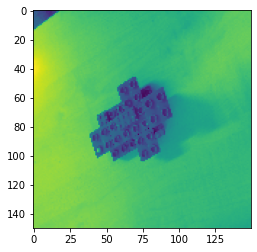

Valos:  0 , tippelt:  1


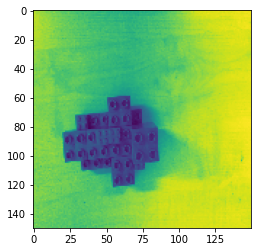

Valos:  0 , tippelt:  1


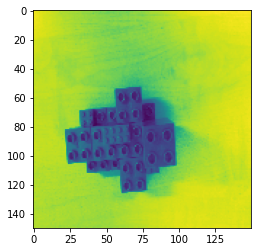

Valos:  2 , tippelt:  1


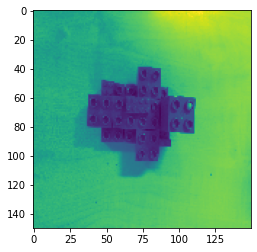

Valos:  1 , tippelt:  0


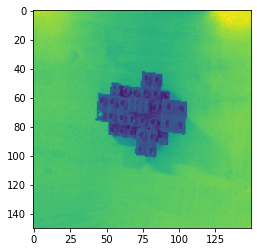

Valos:  0 , tippelt:  2


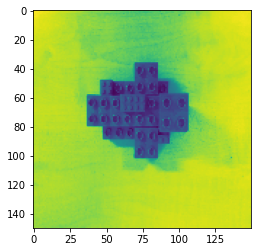

Valos:  1 , tippelt:  0


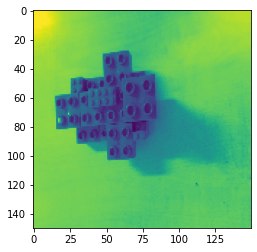

Valos:  2 , tippelt:  1


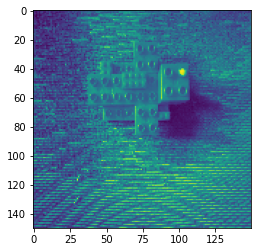

Valos:  2 , tippelt:  1


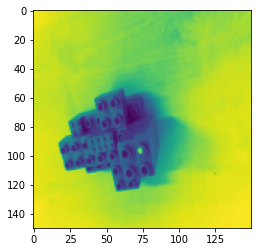

Valos:  1 , tippelt:  0


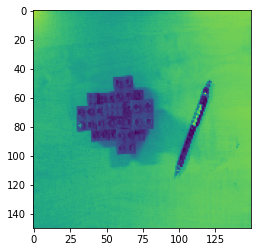

Valos:  2 , tippelt:  1


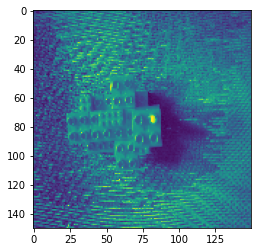

Valos:  1 , tippelt:  0


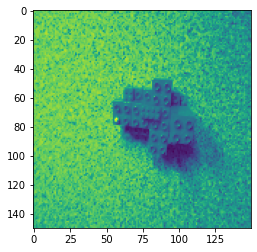

Valos:  0 , tippelt:  2


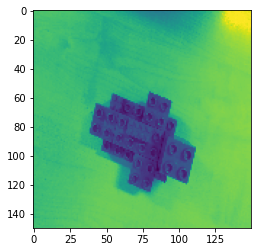

Valos:  0 , tippelt:  1


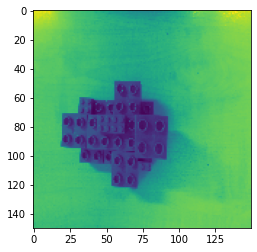

Valos:  2 , tippelt:  1


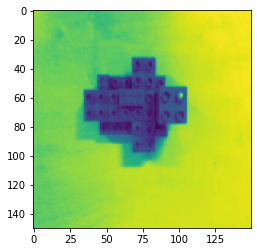

Valos:  1 , tippelt:  0


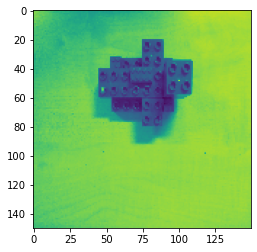

Valos:  1 , tippelt:  2


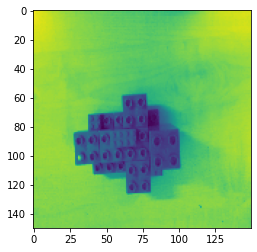

Valos:  1 , tippelt:  0


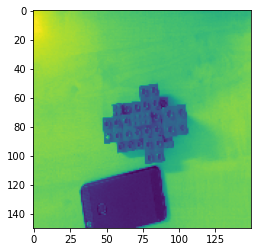

Valos:  2 , tippelt:  1


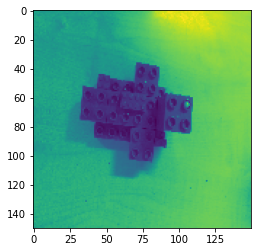

Valos:  0 , tippelt:  2


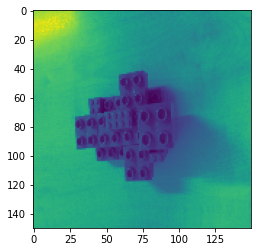

Valos:  2 , tippelt:  1


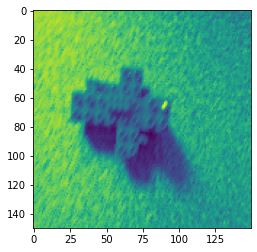

Valos:  1 , tippelt:  0


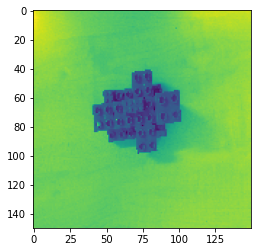

Valos:  0 , tippelt:  1


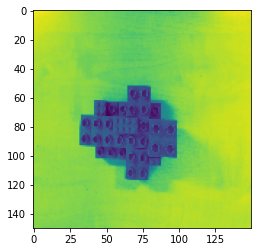

Valos:  1 , tippelt:  0


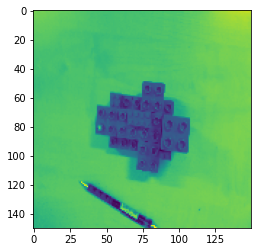

Valos:  2 , tippelt:  1


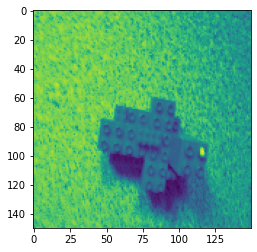

Valos:  2 , tippelt:  1


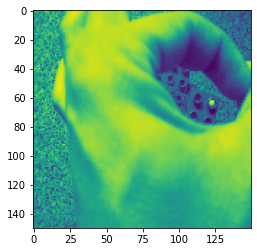

Valos:  2 , tippelt:  1


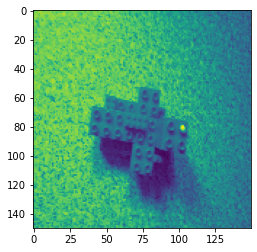

Valos:  1 , tippelt:  0


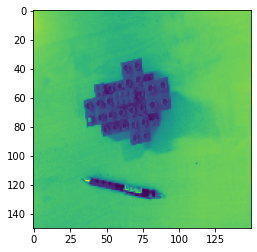

Valos:  2 , tippelt:  0


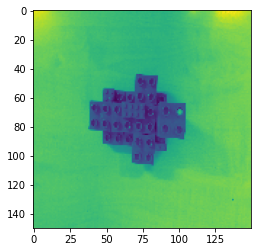

Valos:  1 , tippelt:  2


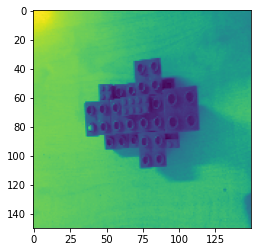

Valos:  2 , tippelt:  1


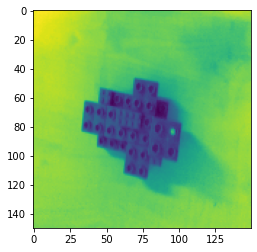

Valos:  2 , tippelt:  0


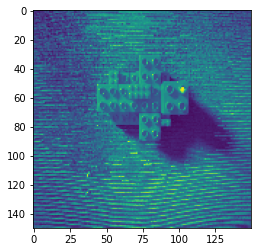

Valos:  2 , tippelt:  0


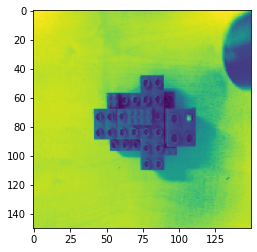

Valos:  1 , tippelt:  0


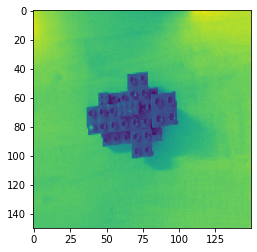

Valos:  2 , tippelt:  0


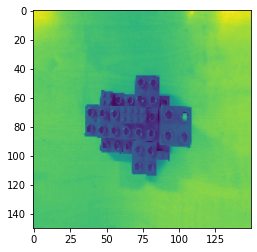

Valos:  1 , tippelt:  0


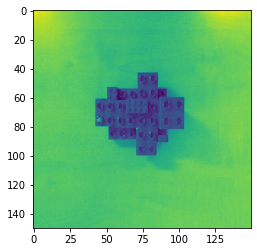

Valos:  2 , tippelt:  0


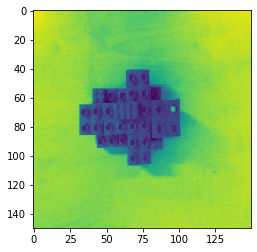

Valos:  0 , tippelt:  1


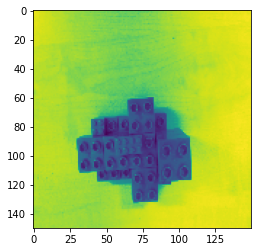

Valos:  1 , tippelt:  2


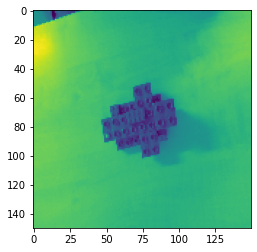

Valos:  1 , tippelt:  0


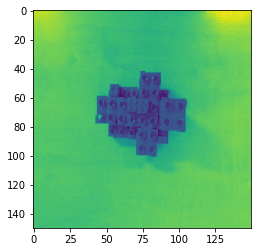

Valos:  0 , tippelt:  2


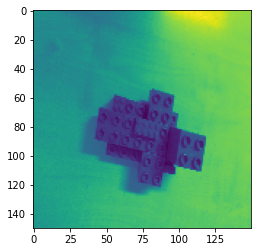

Valos:  2 , tippelt:  0


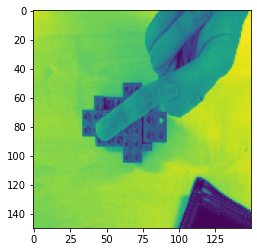

Valos:  1 , tippelt:  2


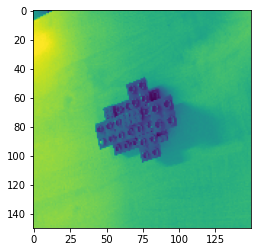

Valos:  2 , tippelt:  0


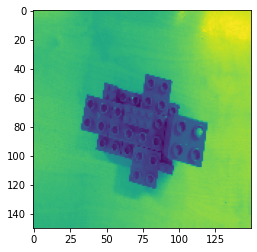

Valos:  0 , tippelt:  2


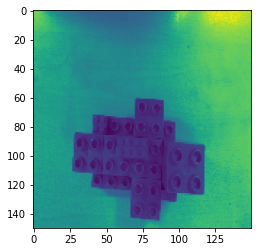

Valos:  0 , tippelt:  2


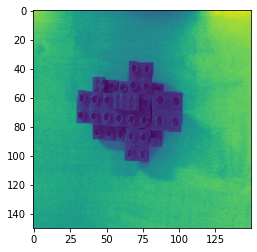

In [43]:
from matplotlib.pyplot import imshow, show    


for i in range(bad_num):
    print("Valos: ", real[i].item(), ", tippelt: ", bad_dec[i].item())
    plt.imshow(bad_pics[i].reshape(IMG_SIZE,IMG_SIZE))
    show()